In [1]:
import json
import os
import pandas as pd
import pprint
import sdv

In [21]:
import matplotlib.pyplot as plt

In [49]:
# import numpy as np
from ydata_profiling import ProfileReport

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [50]:
all_exp_datasets = ["adult", "census", "child", "covtype", "credit", "insurance", 
                    "intrusion", "health_insurance", "drugs", "loan", "nasdaq", "taxi", "pums"]

In [5]:
from sdv.datasets.demo import get_available_demos, download_demo

In [6]:
datasets_df = get_available_demos(modality='single_table')
datasets_df

,dataset_name,size_MB,num_tables
0,KRK_v1,0.07,1
1,adult,3.91,1
2,alarm,4.52,1
3,asia,1.28,1
4,census,98.17,1
5,census_extended,4.95,1
6,child,3.20,1
7,covtype,255.65,1
8,credit,68.35,1
9,expedia_hotel_logs,0.20,1


In [7]:
def get_dataset_with_sdv(modality, dataset_name):
    real_data, metadata = download_demo(
        modality=modality,
        dataset_name=dataset_name,
)

In [8]:
seq_datasets_df = get_available_demos(modality='sequential')
seq_table_dataset_names = seq_datasets_df["dataset_name"]

In [9]:
seq_datasets_df

,dataset_name,size_MB,num_tables
0,ArticularyWordRecognition,8.61,1
1,AtrialFibrillation,0.92,1
2,BasicMotions,0.64,1
3,CharacterTrajectories,19.19,1
4,Cricket,17.24,1
5,DuckDuckGeese,291.38,1
6,ERing,1.25,1
7,EchoNASDAQ,4.16,1
8,EigenWorms,372.63,1
9,Epilepsy,3.17,1


## Generate Data Profiles

In [ ]:
for dataset_name in all_exp_datasets:
    print("-*-"*10)
    print(" "*4, dataset_name)
    print("-*-"*10)
    
    output_path = f"dataset_profiles/{dataset_name}"
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    df = pd.read_csv(f"data/tabular/{dataset_name}.csv")
    profile = ProfileReport(df, minimal=False)
    
    # As a JSON string
    json_data = profile.to_json()
        
    json_dict = json.loads(json_data)
    var_profiles = get_minimal_profile(json_dict)
        
    # Save the dictionary as a JSON file
    with open(f"{output_path}/{dataset_name}.json", "w") as json_file:
        json.dump(var_profiles, json_file)

    # As a file
    profile.to_file(f"{output_path}/{dataset_name}_detailed.json")
    profile.to_file(f"{output_path}/{dataset_name}.html")

In [15]:
cmp_datasets = {
    "name": [],
    "memory_size": [],
    "record_size": [],
    "p_duplicates": [],
    "p_cells_missing": [],
    "n_rows": [],
    "n_cols": [],
    "n_numeric": [],
    "n_categoric": [],
    "n_boolean": [], 
    "n_datetime": [], 
    "n_text": []
}

n_distinct_cats = {}

for dn in all_exp_datasets:
    try:
        # Load the JSON file into a dictionary
        with open(f"../dataset_details/profiles/{dn}.json", "r") as json_file:
            data_dict = json.load(json_file)
        tab_data = data_dict["table"]
        cmp_datasets["name"].append(dn)
        cmp_datasets["memory_size"].append(tab_data["memory_size"])
        cmp_datasets["record_size"].append(tab_data["record_size"])
        try:
            cmp_datasets["p_duplicates"].append(tab_data["p_duplicates"])
        except Exception as e:
            cmp_datasets["p_duplicates"].append("NA")
            print(e)
        cmp_datasets["p_cells_missing"].append(tab_data["p_cells_missing"])
        cmp_datasets["n_rows"].append(tab_data["n"])
        cmp_datasets["n_cols"].append(tab_data["n_var"])
        cmp_datasets["n_numeric"].append(tab_data["types"]["Numeric"])
        try:
            cmp_datasets["n_categoric"].append(tab_data["types"]["Categorical"])
        except Exception as e:
            cmp_datasets["n_categoric"].append(0)
        try:
            cmp_datasets["n_boolean"].append(tab_data["types"]["Boolean"])
        except Exception as e:
            cmp_datasets["n_boolean"].append(0)
            
        try:
            cmp_datasets["n_text"].append(tab_data["types"]["Text"])
        except Exception as e:
            cmp_datasets["n_text"].append(0)
            
        try:
            cmp_datasets["n_datetime"].append(tab_data["types"]["DateTime"])
        except Exception as e:
            cmp_datasets["n_datetime"].append(0)
        
        # print("-"*30, dn.upper())
        data_cat_cols = {}
        for column, details in data_dict["variables"].items():
            if details["type"] == "Categorical":
                # print(f"{column}: n_distinct = {details['n_distinct']}")
                data_cat_cols[column] = details['n_distinct']
        n_distinct_cats[dn] = data_cat_cols
            
        # print(data_dict["alerts"])
        # print("-"*30)
             
    except Exception as e: 
        print(e)
        
with open(f"n_distinct_cats.json", "w") as json_file:
    json.dump(n_distinct_cats, json_file)

'p_duplicates'
'p_duplicates'
'p_duplicates'


In [16]:
def get_minimal_profile(variables_dict):
    profiles = {}
    profiles["table"] = variables_dict["table"]
    profiles["alerts"] = variables_dict["alerts"]
    profiles["variables"] = {}
    for k, v in variables_dict["variables"].items():
        dtype = v["type"]
        var_profile = {}
        
        # Supported Ydata types
        # - Boolean
        # - Numerical
        # - Date (and Datetime)
        # - Categorical
        # - Time-series
        # - URL
        # - Path
        # - File
        # - Image
        if dtype == "Categorical":
            var_profile = {
                "type": dtype,
                "n_distinct": v["n_distinct"],
                "n_missing": v["n_missing"],
                "freq_counts": v["word_counts"],
                "imbalance": v["imbalance"]
            }
        elif dtype == "Numeric":
            var_profile = {
                "type": dtype,
                "n_distinct": v["n_distinct"],
                "n_missing": v["n_missing"],             
                "kurtosis": v["kurtosis"],
                "skewness": v["skewness"],
                "monotonic": v["monotonic"]
            }
        elif dtype == "Boolean":
            var_profile = {
                "type": dtype,
                "n_distinct": v["n_distinct"],
                "n_missing": v["n_missing"],
                "imbalance": v["imbalance"]
            }
        else:    
            var_profile = v
            print("None a valid type : ", dtype)
        profiles["variables"][k] = var_profile
    return profiles

In [18]:
def plot_target_distribution(df, dataset_name, col_name='label'):
    # Count the frequency of each category
    category_counts = df[col_name].value_counts()

    # Plot the frequency graph using pandas
    category_counts.plot(kind='bar')

    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.title(dataset_name)
    plt.show()

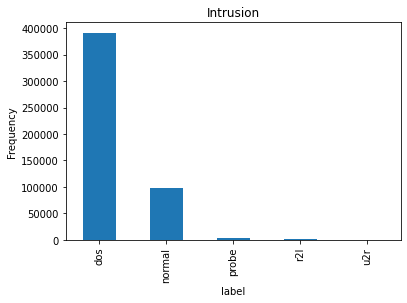

In [22]:
df = pd.read_csv("../all_sample_datasets/Intrusion.csv")
plot_target_distribution(df, "Intrusion", "label")

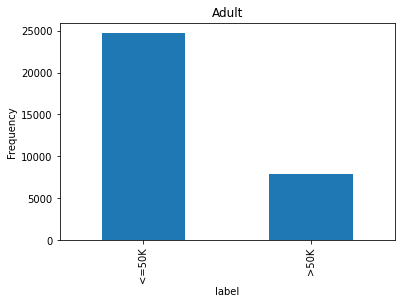

In [23]:
df = pd.read_csv("../all_sample_datasets/Adult.csv")
plot_target_distribution(df, "Adult", "label")

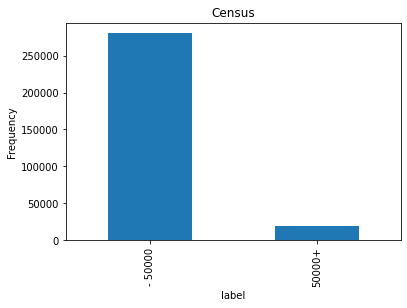

In [24]:
df = pd.read_csv("../all_sample_datasets/Census.csv")
plot_target_distribution(df, "Census", "label")

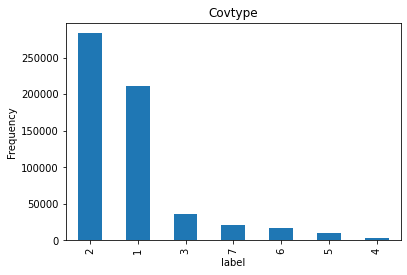

In [25]:
df = pd.read_csv("../all_sample_datasets/Covtype.csv")
plot_target_distribution(df, "Covtype", "label")

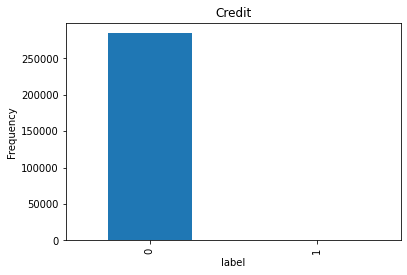

In [26]:
df = pd.read_csv("../all_sample_datasets/Credit.csv")
plot_target_distribution(df, "Credit", "label")

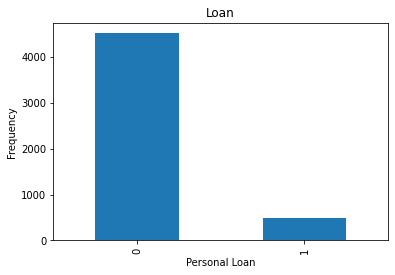

In [28]:
df = pd.read_csv("../all_sample_datasets/loan.csv")
plot_target_distribution(df, "Loan", "Personal Loan")

In [29]:
ALL_TABULAR_DATASETS = ["adult", "census", "child", "covtype", "credit", "insurance", 
                       "health_insurance", "intrusion", "drugs", "loan", "pums"]

In [30]:
def detect_metadata_with_sdv(real_data_df: pd.DataFrame):
    """
    Automatically detect the metadata based on your actual data using SDV API.
    Args:
        real_data_df: pandas.DataFrame 
    Returns: 
        metadata: SingleTableMetadata
    """
    metadata = sdv.metadata.SingleTableMetadata()
    metadata.detect_from_dataframe(data=real_data_df)
    return metadata


In [ ]:
for dataset in ALL_TABULAR_DATASETS:
    
    try:
        df = pd.read_csv(f"../all_sample_datasets/{dataset}.csv")
        md = detect_metadata_with_sdv(df)
        python_dict = md.to_dict()

        with open(f"{dataset}_md.json", "w") as json_file:
            json.dump(python_dict, json_file)
    except Exception as e:
        print(e)

In [33]:
cats_c = {
    "dataset": [],
    "numerical": [],
    "categorical": [],
    "ID": [],
    "Other": [], 
    "ALL": []
} 

for dataset in ALL_TABULAR_DATASETS:    
    with open(f"../dataset_details/metadata_dict/{dataset}_md.json", "r") as json_file:
        # print("_"*20, dataset, "_"*20)
        md_dict = json.load(json_file)
        
        num_c = 0
        cat_c = 0
        id_c = 0
        other_c = 0
        
        for k, v in md_dict["columns"].items():
            sdtype = v["sdtype"]
            if sdtype == "numerical":
                num_c += 1
            elif sdtype == "categorical":
                cat_c += 1
            elif sdtype == "id":
                id_c += 1
            else:
                other_c += 1
                
        cats_c["dataset"].append(dataset)
        cats_c["numerical"].append(num_c)
        cats_c["categorical"].append(cat_c)
        cats_c["ID"].append(id_c)
        cats_c["Other"].append(other_c)
        cats_c["ALL"].append(other_c + num_c + cat_c + id_c)

In [34]:
cat_df = pd.DataFrame(cats_c)
cat_df

,dataset,numerical,categorical,ID,Other,ALL
0,adult,6,9,1,0,16
1,census,8,33,1,0,42
2,child,0,20,1,0,21
3,covtype,10,45,1,0,56
4,credit,29,1,1,0,31
5,insurance,0,27,1,0,28
6,health_insurance,3,4,0,0,7
7,intrusion,11,30,1,0,42
8,drugs,1,37,1,1,40
9,loan,6,7,1,0,14


In [37]:
# cmp_datasets = {
#     "name": [],
#     "memory_size": [],
#     "record_size": [],
#     "p_duplicates": [],
#     "p_cells_missing": [],
#     "n_rows": [],
#     "n_cols": [],
#     "n_numeric": [],
#     "n_categoric": [],
#     "n_boolean": [], 
#     "n_datetime": [], 
#     "n_text": []
# }

# n_distinct_cats = {}

# for dn in all_exp_datasets:
#     try:
#         # Load the JSON file into a dictionary
#         with open(f"../dataset_profiles/{dn}.json", "r") as json_file:
#             data_dict = json.load(json_file)
#         tab_data = data_dict["table"]
#         cmp_datasets["name"].append(dn)
#         cmp_datasets["memory_size"].append(tab_data["memory_size"])
#         cmp_datasets["record_size"].append(tab_data["record_size"])
#         try:
#             cmp_datasets["p_duplicates"].append(tab_data["p_duplicates"])
#         except Exception as e:
#             cmp_datasets["p_duplicates"].append("NA")
#             print(e)
#         cmp_datasets["p_cells_missing"].append(tab_data["p_cells_missing"]*100)
#         cmp_datasets["n_rows"].append(tab_data["n"])
#         cmp_datasets["n_cols"].append(tab_data["n_var"])
#         cmp_datasets["n_numeric"].append(tab_data["types"]["Numeric"])
#         try:
#             cmp_datasets["n_categoric"].append(tab_data["types"]["Categorical"])
#         except Exception as e:
#             cmp_datasets["n_categoric"].append(0)
#         try:
#             cmp_datasets["n_boolean"].append(tab_data["types"]["Boolean"])
#         except Exception as e:
#             cmp_datasets["n_boolean"].append(0)
            
#         try:
#             cmp_datasets["n_text"].append(tab_data["types"]["Text"])
#         except Exception as e:
#             cmp_datasets["n_text"].append(0)
            
#         try:
#             cmp_datasets["n_datetime"].append(tab_data["types"]["DateTime"])
#         except Exception as e:
#             cmp_datasets["n_datetime"].append(0)
        
#         # print("-"*30, dn.upper())
#         data_cat_cols = {}
#         for column, details in data_dict["variables"].items():
#             if details["type"] == "Categorical":
#                 # print(f"{column}: n_distinct = {details['n_distinct']}")
#                 data_cat_cols[column] = details['n_distinct']
#         n_distinct_cats[dn] = data_cat_cols
            
#         # print(data_dict["alerts"])
#         # print("-"*30)
             
#     except Exception as e: 
#         print(e)
        
# with open(f"n_distinct_cats.json", "w") as json_file:
#     json.dump(n_distinct_cats, json_file)

In [39]:
def bytes_to_megabytes(bytes):
    return bytes / (1024 * 1024)
data_sizes = list(cmp_datasets_df["memory_size"]) 

In [40]:
for bytes_value in data_sizes:
    # Example usage
    # bytes_value = 306419920  # Replace with your bytes value
    megabytes = bytes_to_megabytes(bytes_value)
    print(f"{bytes_value} bytes is equal to {megabytes} MB")


## Categorical and Numeric Distributions in Datasets 

In [41]:
sorted_cmp_datasets_df = cmp_datasets_df.sort_values(by='memory_size')

sorted_cmp_datasets_df['size_in_MB'] = sorted_cmp_datasets_df['memory_size'] / (1024 * 1024)
sorted_cmp_datasets_df

,name,memory_size,record_size,p_duplicates,p_cells_missing,n_rows,n_cols,n_numeric,n_categoric,n_boolean,n_datetime,n_text,size_in_MB


In [42]:
# cat_df["perct_categorical"] = [ for num_cat in cat_df["categorical"]] 
cat_df['percent_categorical'] = (cat_df['categorical'] / cat_df['ALL']) * 100
cat_df['percent_numerical'] = (cat_df['numerical'] / cat_df['ALL']) * 100
cat_df

,dataset,numerical,categorical,ID,Other,ALL,percent_categorical,percent_numerical
0,adult,6,9,1,0,16,56.250000,37.500000
1,census,8,33,1,0,42,78.571429,19.047619
2,child,0,20,1,0,21,95.238095,0.000000
3,covtype,10,45,1,0,56,80.357143,17.857143
4,credit,29,1,1,0,31,3.225806,93.548387
5,insurance,0,27,1,0,28,96.428571,0.000000
6,health_insurance,3,4,0,0,7,57.142857,42.857143
7,intrusion,11,30,1,0,42,71.428571,26.190476
8,drugs,1,37,1,1,40,92.500000,2.500000
9,loan,6,7,1,0,14,50.000000,42.857143


# Cardinality of Categorical Columns

In [46]:
for dataset in ALL_TABULAR_DATASETS: 
    
    print("_"*20, dataset, "_"*20)
    
    md_file = f"../dataset_details/metadata_dict/{dataset}_md.json"
    with open(md_file, 'r') as file:
        md_dict = json.load(file)
    
    df = pd.read_csv(f"../all_sample_datasets/{dataset}.csv")
        
    for k, v in md_dict["columns"].items():
        sdtype = v["sdtype"]
        if sdtype == "categorical":
            cardinality = df[k].nunique()
            if cardinality >= 8:
                print(f"Column {k} : {df[k].nunique()}")

____________________ adult ____________________
Column workclass : 9
Column education : 16
Column occupation : 15
Column native-country : 42
____________________ census ____________________
Column class of worker : 9
Column education : 17
Column major industry code : 24
Column major occupation code : 15
Column hispanic origin : 9
Column full or part time employment stat : 8
Column state of previous residence : 51
Column detailed household and family stat : 38
Column detailed household summary in household : 8
Column migration code-change in msa : 10
Column migration code-change in reg : 9
Column migration code-move within reg : 10
Column country of birth father : 43
Column country of birth mother : 43
Column country of birth self : 43
____________________ child ____________________
____________________ covtype ____________________
____________________ credit ____________________
____________________ insurance ____________________
____________________ health_insurance __________________

# Alerts (Data qaulity checks)

In [45]:
for dn in all_exp_datasets:
    try:
        # Load the JSON file into a dictionary
        with open(f"../dataset_details/profiles/{dn}.json", "r") as json_file:
            print("_"*20, dn, "_"*20)
            data_dict = json.load(json_file)
            pprint.pprint(data_dict["alerts"])
            
    except Exception as e:
        print(e)

____________________ adult ____________________
['[education-num] is highly overall correlated with [education]',
 '[education] is highly overall correlated with [education-num]',
 '[relationship] is highly overall correlated with [sex]',
 '[sex] is highly overall correlated with [relationship]',
 '[race] is highly imbalanced (0.6560011256280069)',
 '[native-country] is highly imbalanced (0.8249740622065667)',
 '[Unnamed: 0] is uniformly distributed',
 '[Unnamed: 0] has unique values',
 '[capital-gain] has 29849 (91.7%) zeros',
 '[capital-loss] has 31042 (95.3%) zeros']
____________________ census ____________________
['[age] is highly overall correlated with [veterans benefits]',
 '[detailed industry recode] is highly overall correlated with [detailed '
 'occupation recode] and 3 other fields',
 '[detailed occupation recode] is highly overall correlated with [detailed '
 'industry recode] and 3 other fields',
 '[num persons worked for employer] is highly overall correlated with '
 '[d